In [1]:
import pystan
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import multiprocessing
multiprocessing.set_start_method("fork")


In [3]:
#! need to change sigma in two places!
model = """
data {
  int<lower=0> N;
  vector[N] y;
}
parameters {
  real mu;
}
model {
  real sigma=1;
  real mu0=0;
  real sigma0=10;
  mu ~ normal(mu0, sigma0);
  y ~ normal(mu, sigma);
}
generated quantities {
  vector[N] log_lik;
  real sigma=1;
  for (n in 1:N) 
    log_lik[n] = normal_lpdf(y[n] | mu, sigma);
}
"""

# compile the model
sm = pystan.StanModel(model_code=model)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2214e789e3dd09a92dda4ee012dc92d7 NOW.


In [9]:
np.random.seed(1)

N = 100
sigma = 1
mu = 3
mu0 = 0
sigma0 = 10
y = np.random.normal(loc=mu, scale=sigma, size=N)

# put our data in a dictionary
data = {'N': N, 'y': y}

In [10]:
# train the model and generate samples
fit = sm.sampling(n_jobs=1, data=data, iter=1000, chains=4, warmup=500, thin=1, seed=1)

In [11]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_2214e789e3dd09a92dda4ee012dc92d7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu            3.06  3.5e-3    0.1   2.86   2.99   3.06   3.12   3.24    777    1.0
log_lik[1]   -2.15  5.5e-3   0.15  -2.48  -2.25  -2.15  -2.05  -1.87    772    1.0
log_lik[2]   -1.15  2.4e-3   0.07  -1.28  -1.19  -1.14   -1.1  -1.03    771    1.0
log_lik[3]   -1.09  2.1e-3   0.06  -1.22  -1.13  -1.09  -1.05  -0.99    769    1.0
log_lik[4]   -1.56  4.0e-3   0.11  -1.78  -1.63  -1.56  -1.49  -1.35    774    1.0
log_lik[5]   -1.25  2.9e-3   0.08  -1.43   -1.3  -1.25  -1.19  -1.11    769    1.0
log_lik[6]   -3.71  8.3e-3   0.23  -4.15  -3.86   -3.7  -3.55  -3.25    777    1.0
log_lik[7]   -2.35  5.9e-3   0.16   -2.7  -2.46  -2.34  -2.23  -2.05    773    1.0
log_lik[8]   -1.26  2.9e-3

In [12]:
# gather into dataframe
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
lp = fit["lp__"]
mu_pos = fit["mu"]

loglik_val = fit["log_lik"].sum(axis=1)

In [13]:
np.mean(mu_pos), np.std(mu_pos)

(3.0570127266836185, 0.09751885023554471)

In [18]:
def log_posterior(mu, sigma, mu0, sigma0, y):
    N = len(y)
    sd = (1 / sigma0**2 + N / sigma**2)**(-1)
    mean = sd * (mu0 / sigma0**2 + np.sum(y) / sigma**2)
    log_pos = - 1 / (2*sd**2) * (mu - mean)**2
    return log_pos


def loglik(mu, sigma, y):
    # N = len(y)
    term1 = - 0.5 * np.log(2 * np.pi * sigma**2)
    term2 = - 1/(2 * sigma**2) * (y - mu)**2
    return term1 + term2

def posterior_den(mu, y):
    true_pos_var = (1 / sigma0**2 + len(y) / sigma**2)**(-1)
    true_pos_mean = true_pos_var * (mu0 / sigma0**2 + np.sum(y) / sigma**2)
    return norm.pdf(mu, loc=true_pos_mean, scale=np.sqrt(true_pos_var))


In [28]:
print("loglik:", loglik_val[0], loglik(mu_pos[0], sigma, y).sum() + norm.logpdf(mu_pos[0], loc=mu0, scale=sigma0))
print("posterior:", lp[0], loglik(mu_pos[0], sigma, y).sum() + norm.logpdf(mu_pos[0], loc=mu0, scale=sigma0))

loglik: -131.3299095142406 -134.60050624877482
posterior: -41.78771439510288 -134.60050624877482


In [30]:
for i in range(5):
    print(lp[i] - (loglik(mu_pos[i], sigma, y).sum() + norm.logpdf(mu_pos[i], loc=mu0, scale=sigma0)))

92.81279185367194
92.81279185367191
92.81279185367192
92.81279185367194
92.81279185367194


-131.3299095142406 -131.32990951424057


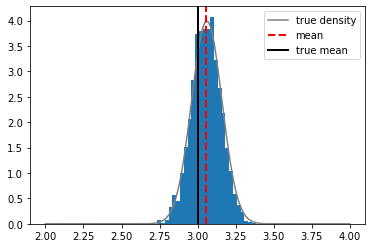

In [19]:
# log_posterior(mu_pos, sigma, mu0=0, sigma0=1, y=y)
print(loglik_val[0], loglik(mu_pos[0], sigma, y).sum())


# plot posterior samples and mean
x_plot = np.linspace(2, 4, 500)
plt.hist(mu_pos, 30, density=True)
plt.plot(x_plot, posterior_den(x_plot, y), color="grey", label="true density")
plt.axvline(np.mean(mu_pos), color='r', lw=2, linestyle='--',label='mean')
plt.axvline(mu, color='k', lw=2, linestyle='-',label='true mean')
plt.legend()
plt.show()

In [11]:
# add new data and update posterior samples
n_new = 100
y_new = np.zeros(n_new)
mu_hat = np.zeros(n_new)
mu_hat[0] = mu_pos.mean()
for i in range(1, n_new):
    y_new_val = np.random.normal(loc=mu, scale=sigma, size=1)
    weights = np.exp(loglik(mu_pos, sigma, y_new_val))
    mu_hat[i] = (mu_pos * weights / weights.sum()).sum()
    y_new[i] = y_new_val

    if (i+1) % 10 == 0:
        print("MSE:", np.mean((mu_hat[i] - mu)**2))


# y_full = np.vstack((y.reshape(-1, 1), y_new.reshape(-1, 1)))
# true_pos_sd = (1 / sigma0**2 + len(y_full) / sigma**2)**(-1)
# true_pos_mean = true_pos_sd * (mu0 / sigma0**2 + np.sum(y_full) / sigma**2)
# x_plot = np.linspace(0, 6, 500)
# # true_pos_den = norm.pdf(x_plot, loc=true_pos_mean, scale=true_pos_sd)
# true_pos_sample = np.random.normal(loc=true_pos_mean, scale=true_pos_sd, size=1000)





MSE: 0.011016430753745119
MSE: 0.018103337606946115
MSE: 0.002712196104636783
MSE: 0.009504536150839966
MSE: 0.0066592437570996395
MSE: 0.010841588634587005
MSE: 0.007558379527502618
MSE: 0.009473482697629184
MSE: 0.02818352919415477
MSE: 0.018060642659209633


In [ ]:
plt.scatter(range(n_new), mu_hat)
plt.axhline(mu, color="k", lw=2, linestyle="-",label="true mean")
plt.legend()
plt.show()

plt.hist(mu_hat, 30, density=True, label="sampled posterior", alpha=0.5)
plt.hist(true_pos_sample, 30, density=True, color="grey", label="true density", alpha=0.5)
plt.show()

# plt.hist(mu_hat, 30, density=True)
# plt.scatter(x_plot, true_pos_den, color="grey", label="true density")
# plt.show()